In [1]:
import pandas as pd
from print_nanny_webapp.client_events.models import PredictEvent
from django.utils import timezone
from asgiref.sync import sync_to_async
import os

import matplotlib


WARNING 2020-11-17 13:25:59,586 __init__ 29 140317836441408 Matplotlib created a temporary config/cache directory at /tmp/matplotlib-7l3t5zuh because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
CONFIDENCE_THRESHOLD = 0.50

LABELS = {
    1: 'nozzle',
    2: 'adhesion',
    3: 'spaghetti',
    4: 'print',
    5: 'raft',
}

FAILURES = {
    2: 'adhesion',
    3: 'spaghetti',  
}


In [3]:
import json
def dict_to_series(data):
    return pd.Series(data.values(), index=data.keys())

In [4]:
predict_events = PredictEvent.objects.all().order_by('-dt').values('id','predict_data')

df = pd.DataFrame.from_records(predict_events, index='id')
df = df['predict_data'].apply(dict_to_series)

NUM_DETECTIONS = len(df['detection_scores'].iloc[0])
print(NUM_DETECTIONS)

40


In [5]:
df = df.dropna()
df = df[['detection_classes', 'detection_scores']]
df = df.reset_index()
df = df.rename(columns={'id': 'frame_id' })

NUM_FRAMES = len(df)
df

,frame_id,detection_classes,detection_scores
0,658,"[4, 4, 1, 3, 3, 1, 3, 5, 1, 4, 2, 3, 5, 1, 3, ...","[0.08984375, 0.05078125, 0.03515625, 0.0273437..."
1,657,"[1, 4, 1, 5, 5, 1, 3, 2, 1, 3, 3, 3, 3, 3, 1, ...","[0.08984375, 0.06640625, 0.05078125, 0.0507812..."
2,656,"[4, 1, 5, 5, 3, 3, 5, 3, 1, 3, 3, 3, 3, 1, 3, ...","[0.12109375, 0.08984375, 0.06640625, 0.0664062..."
3,655,"[4, 1, 4, 5, 1, 1, 3, 5, 1, 2, 3, 5, 3, 5, 4, ...","[0.06640625, 0.06640625, 0.05078125, 0.0507812..."
4,654,"[5, 5, 4, 1, 1, 3, 5, 5, 3, 1, 2, 3, 3, 1, 3, ...","[0.08984375, 0.06640625, 0.06640625, 0.0664062..."
...,...,...,...
611,5,"[4, 1, 3, 1, 5, 3, 1, 3, 4, 3, 2, 4, 4, 3, 1, ...","[0.08984375, 0.05078125, 0.03515625, 0.0351562..."
612,4,"[4, 1, 3, 3, 1, 1, 3, 4, 1, 4, 5, 5, 3, 4, 3, ...","[0.16015625, 0.06640625, 0.06640625, 0.0507812..."
613,3,"[1, 4, 5, 1, 3, 1, 5, 5, 5, 5, 3, 3, 4, 3, 4, ...","[0.08984375, 0.08984375, 0.05078125, 0.0507812..."
614,2,"[4, 1, 5, 1, 3, 3, 4, 1, 3, 3, 1, 3, 3, 3, 3, ...","[0.16015625, 0.06640625, 0.05078125, 0.0507812..."


In [6]:
print('Explode detection_classes and detection_scores together')
df = df.set_index(['frame_id']).apply(pd.Series.explode).reset_index()

assert len(df) == NUM_FRAMES * NUM_DETECTIONS
df

Explode detection_classes and detection_scores together


,frame_id,detection_classes,detection_scores
0,658,4,0.0898438
1,658,4,0.0507812
2,658,1,0.0351562
3,658,3,0.0273438
4,658,3,0.0273438
...,...,...,...
24635,1,3,0.0117188
24636,1,1,0.0117188
24637,1,3,0.0117188
24638,1,3,0.0117188


In [7]:
print('Add labels')
df['label'] = df['detection_classes'].map(LABELS)
df


Add labels


,frame_id,detection_classes,detection_scores,label
0,658,4,0.0898438,print
1,658,4,0.0507812,print
2,658,1,0.0351562,nozzle
3,658,3,0.0273438,spaghetti
4,658,3,0.0273438,spaghetti
...,...,...,...,...
24635,1,3,0.0117188,spaghetti
24636,1,1,0.0117188,nozzle
24637,1,3,0.0117188,spaghetti
24638,1,3,0.0117188,spaghetti


In [8]:
print('Create a hierarchal index')
df = df.set_index(['frame_id', 'label'])
df

Create a hierarchal index


detection_classes detection_scores
frame_id label                                       
658      print                     4        0.0898438
         print                     4        0.0507812
         nozzle                    1        0.0351562
         spaghetti                 3        0.0273438
         spaghetti                 3        0.0273438
...                              ...              ...
1        spaghetti                 3        0.0117188
         nozzle                    1        0.0117188
         spaghetti                 3        0.0117188
         spaghetti                 3        0.0117188
         raft                      5        0.0117188

[24640 rows x 2 columns]

INFO 2020-11-17 13:26:00,233 font_manager 29 140317836441408 Generating new fontManager, this may take some time...
Distribution of confidences


array([[<AxesSubplot:title={'center':'adhesion'}>,
        <AxesSubplot:title={'center':'nozzle'}>],
       [<AxesSubplot:title={'center':'print'}>,
        <AxesSubplot:title={'center':'raft'}>],
       [<AxesSubplot:title={'center':'spaghetti'}>, <AxesSubplot:>]],
      dtype=object)

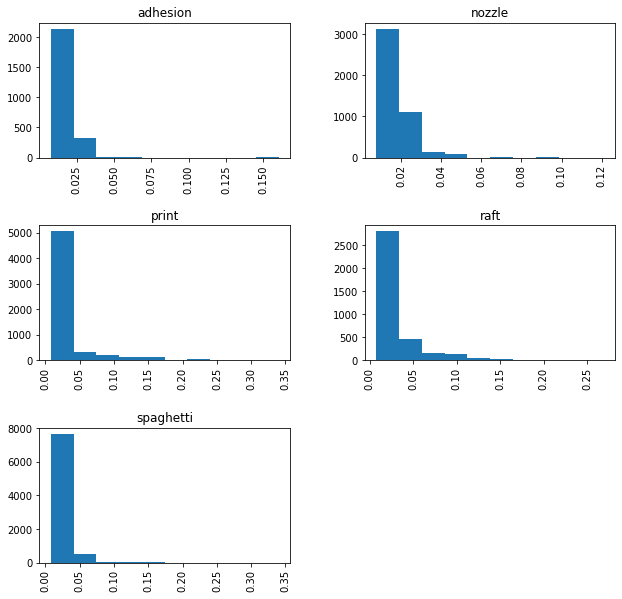

In [9]:
print(f'Distribution of confidences')
df['detection_scores'].hist(by='label', figsize=(10,10))

In [10]:
print(f'Distribution of confidences > {CONFIDENCE_THRESHOLD}')
df[df['detection_scores'] > CONFIDENCE_THRESHOLD]['detection_scores'].hist(by='label', figsize=(10,10))

Distribution of confidences > 0.5


ValueError: Number of columns must be a positive integer, not 0

Distribution of confidence scores > THRESHOLD, FAILURE vs. OK


array([<AxesSubplot:title={'center':'FAILURE'}>,
       <AxesSubplot:title={'center':'NEUTRAL'}>], dtype=object)

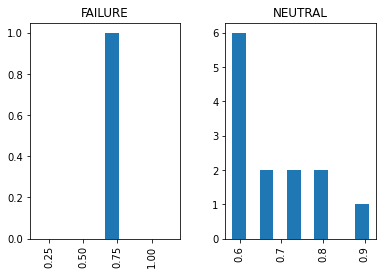

In [1438]:
print('Distribution of confidence scores > THRESHOLD, FAILURE vs. OK')
df[df['detection_scores'] > CONFIDENCE_THRESHOLD]['detection_scores'].hist(by=lambda x: 'FAILURE' if x[1] in FAILURES.values() else 'NEUTRAL' )


In [1439]:
print('Frames where at least 1 type of failure is confidently detected')

mask = (df['detection_scores'] > CONFIDENCE_THRESHOLD) & (df['detection_classes'].isin(FAILURES))

fail_df = df[mask]

fail_df

Frames where at least 1 type of failure is confidently detected


,,detection_classes,detection_scores
frame_id,label,,
94,adhesion,2,0.660156


In [1440]:
print('Percent of frames where at least 1 type of failure is confidently detected')
(len(fail_df) / NUM_FRAMES) * 100

Percent of frames where at least 1 type of failure is confidently detected


0.8620689655172413

In [1441]:
print('Frames where at least 1 type of neutral is confidently detected')

mask = (df['detection_scores'] > CONFIDENCE_THRESHOLD) & (~df['detection_classes'].isin(FAILURES))

neutral_df = df[mask]

neutral_df 

Frames where at least 1 type of neutral is confidently detected


,,detection_classes,detection_scores
frame_id,label,,
86,print,4,0.582031
85,print,4,0.582031
84,print,4,0.660156
81,print,4,0.660156
77,raft,5,0.582031
62,print,4,0.582031
59,print,4,0.582031
47,print,4,0.582031
34,print,4,0.789062


In [1442]:
print('Percent of frames where at least 1 type of neutral (print, raft, nozzle) is confidently detected')
(len(neutral_df ) / NUM_FRAMES) * 100

Percent of frames where at least 1 type of neutral (print, raft, nozzle) is confidently detected


11.206896551724139

In [ ]:
print('Ratio of frames with at least 1 failure detected : frames with at least 1 neutral detected')

len(failed_df) / (len(neutral_df )